# **IMPORT LIBRARY**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Split dataset
from sklearn.model_selection import train_test_split
# Standardscaller
from sklearn.preprocessing import StandardScaler, LabelBinarizer
# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
# Evaluation metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
# Tuning parameter
from sklearn.model_selection import GridSearchCV
# XGBOOST
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# **IMPORT DATA**

### **Read Data**

In [2]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

In [3]:
data_train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [4]:
data_test.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1


### **Data Information**

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1000 non-null   int64  
 1   battery_power  1000 non-null   int64  
 2   blue           1000 non-null   int64  
 3   clock_speed    1000 non-null   float64
 4   dual_sim       1000 non-null   int64  
 5   fc             1000 non-null   int64  
 6   four_g         1000 non-null   int64  
 7   int_memory     1000 non-null   int64  
 8   m_dep          1000 non-null   float64
 9   mobile_wt      1000 non-null   int64  
 10  n_cores        1000 non-null   int64  
 11  pc             1000 non-null   int64  
 12  px_height      1000 non-null   int64  
 13  px_width       1000 non-null   int64  
 14  ram            1000 non-null   int64  
 15  sc_h           1000 non-null   int64  
 16  sc_w           1000 non-null   int64  
 17  talk_time      1000 non-null   int64  
 18  three_g  

# **EXPLORATORY DATA ANALYSIS**

In data exploration, there are 3 important things that need to be done to find out the initial overview of the data, i.e.:
- Checking for missing values
- Data distribution check
- Correlation

## **Missing Value**

In [7]:
data_train.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

## **Data Distribution**

### **Box-plot**

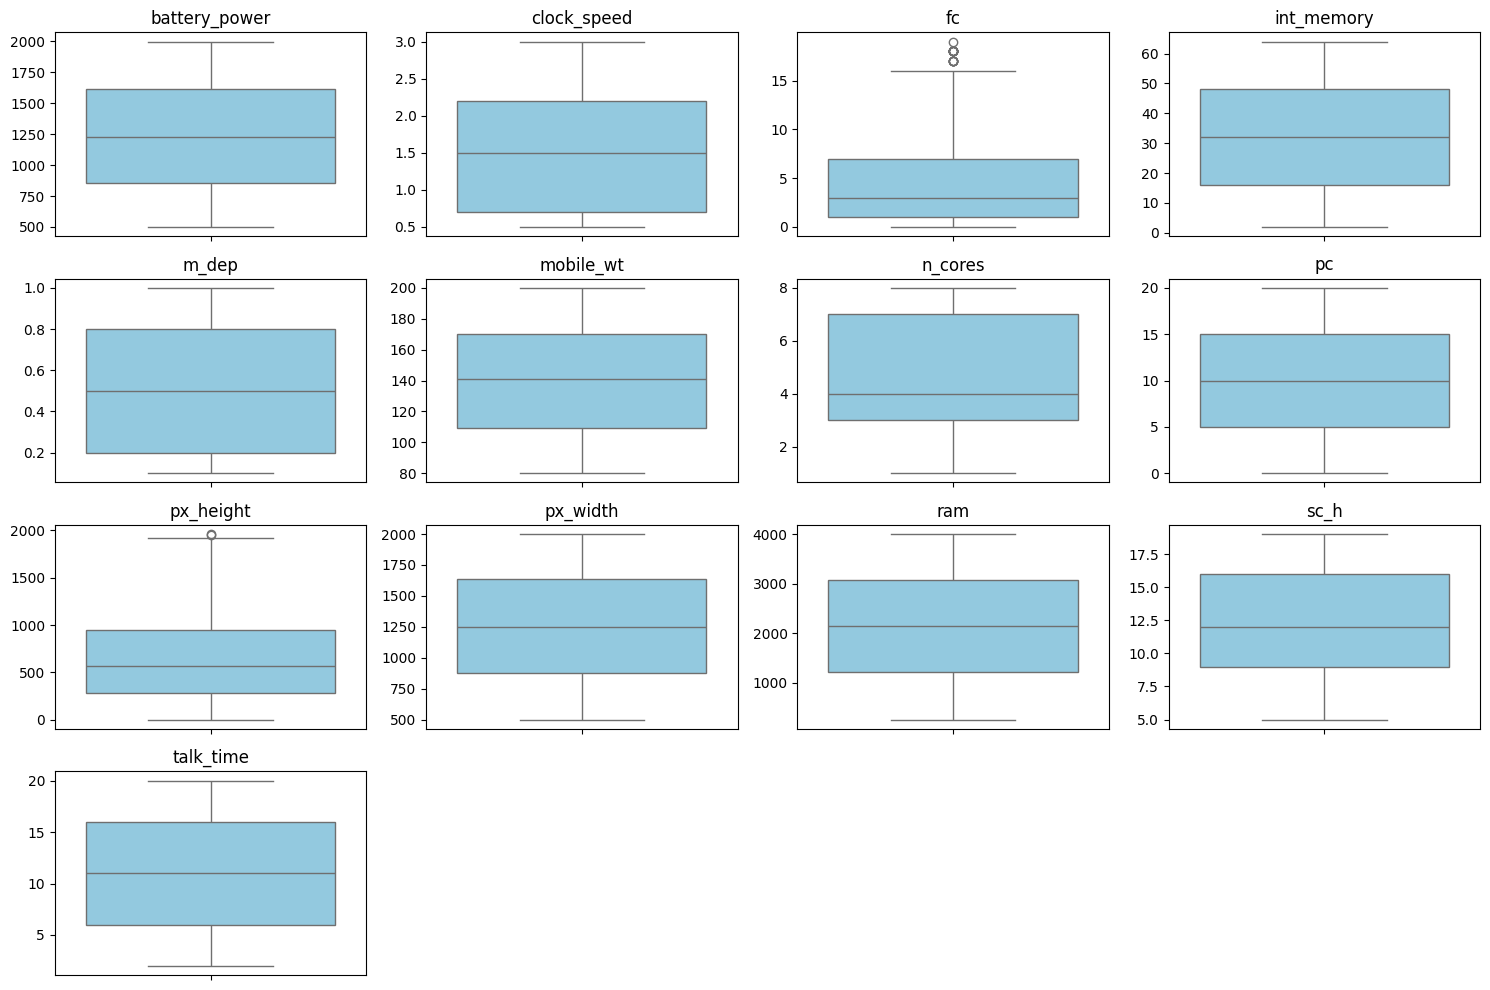

In [8]:
# List numerical column
col_num = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt',
           'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'talk_time']

plt.figure(figsize=(15,10))
for i, column in enumerate(col_num):
  plt.subplot(4,4,i+1)
  sns.boxplot(data = data_train, y=column, color='skyblue')
  plt.title(column, fontsize = 12)
  plt.xlabel('')
  plt.ylabel('')
  plt.tight_layout();

### **Bar-plot**

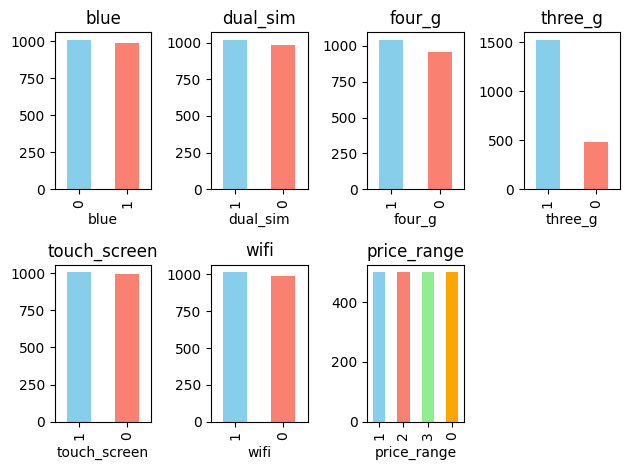

In [9]:
# List categorical column
col_cat = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi', 'price_range']

colors = ['skyblue', 'salmon', 'lightgreen', 'orange']

for i, column in enumerate(col_cat):
    plt.subplot(2, 4, i + 1)
    data_train[column].value_counts().plot(kind='bar', color=colors)
    plt.title(column, fontsize=12)
    plt.ylabel('')
    plt.tight_layout()

## **Correlation**

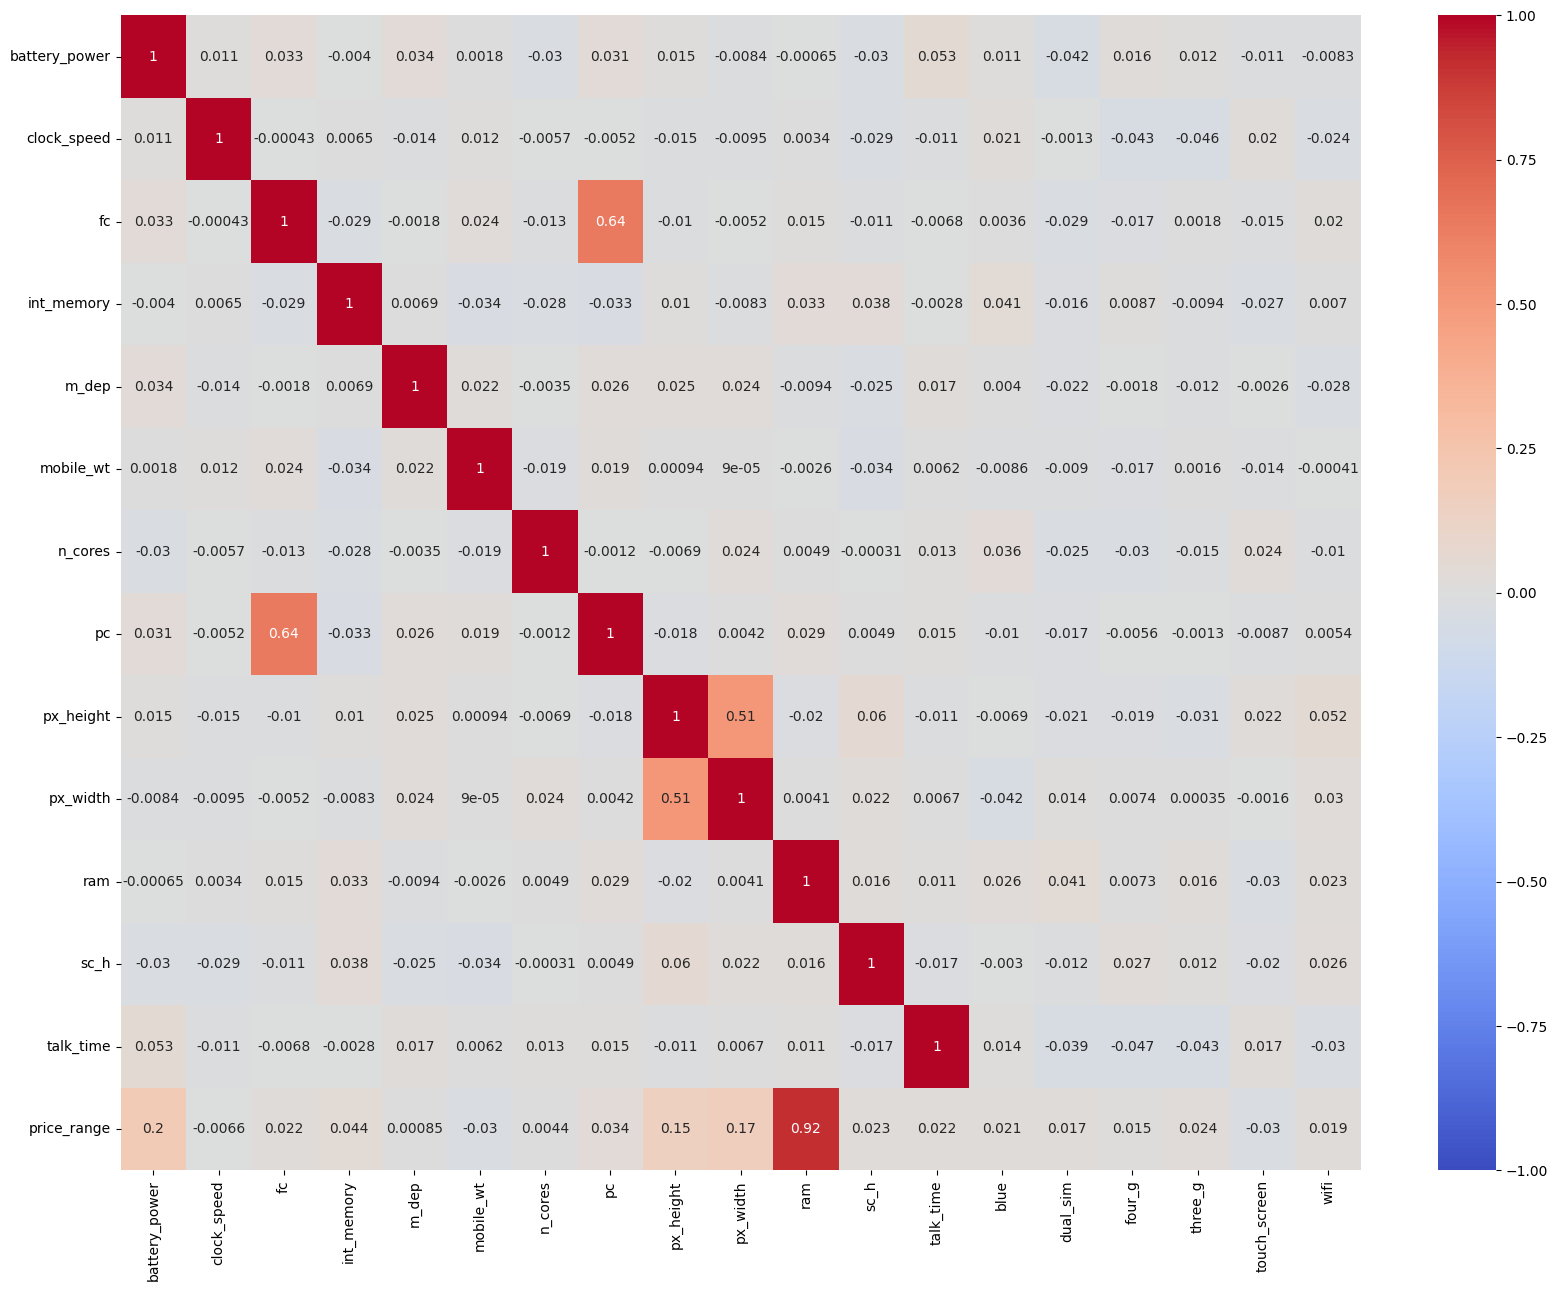

In [10]:
# List numerical column
col_num = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc',
           'px_height', 'px_width', 'ram', 'sc_h', 'talk_time']
# List categorical column
col_cat = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
# Merge column
variables = col_num + col_cat

# Correlation
cor = data_train[variables + ['price_range']].corr()

# Heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(cor.loc[col_num + ['price_range'], variables], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('')
plt.show()

# **DATA PROCESSING**

Then conduct data processing. In this stage, it is categorized into 3 sections, namely:
- Data standardization
- Feature engineering
- Split data

## **Standardization**

In [12]:
# Function to scaling data
def scale_data(data_train):
    # Make copy data
    scaled_data_train = data_train.copy()
    num_fit = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt',
               'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'talk_time']
    # Standardscaler (Z score)
    scaler = StandardScaler()
    scaled_data_train[num_fit] = scaler.fit_transform(scaled_data_train[num_fit])
    return scaled_data_train

scaled_data_train = scale_data(data_train)
print(scaled_data_train)

      battery_power  blue  clock_speed  dual_sim        fc  four_g  \
0         -0.902597     0     0.830779         0 -0.762495       0   
1         -0.495139     1    -1.253064         1 -0.992890       1   
2         -1.537686     1    -1.253064         1 -0.532099       1   
3         -1.419319     1     1.198517         0 -0.992890       0   
4          1.325906     1    -0.395011         0  2.002254       1   
...             ...   ...          ...       ...       ...     ...   
1995      -1.011860     1    -1.253064         1 -0.992890       1   
1996       1.653694     1     1.321096         1 -0.992890       0   
1997       1.530773     0    -0.762748         1 -0.762495       1   
1998       0.622527     0    -0.762748         0 -0.071307       1   
1999      -1.658331     1     0.585621         1  0.159088       1   

      int_memory     m_dep  mobile_wt   n_cores  ...  px_height  px_width  \
0      -1.380644  0.340740   1.349249 -1.101971  ...  -1.408949 -1.146784   
1    

## **Feature Engineering**

In [13]:
# Make feature column to numerical and categorical column
feature_columns = []

# Numerical column
num_fit = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc',
           'px_height', 'px_width', 'ram', 'sc_h', 'talk_time']

for col in num_fit:
  feature_num = tf.feature_column.numeric_column(col)
  feature_columns.append(feature_num)

# Categorical column
cat_fit = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

for col in cat_fit:
    feature_cat = tf.feature_column.categorical_column_with_vocabulary_list(
        key=col,
        vocabulary_list=scaled_data_train[col].unique().tolist()
    )
    feature_cat_onehot = tf.feature_column.indicator_column(feature_cat)
    feature_columns.append(feature_cat_onehot)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


### **Feature Layer**

In [14]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

### **Change to TensorFlow**

In [15]:
# Function to convert dataframe to Tensorflow dataset
def data_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('price_range')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe),labels))

  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))

  ds = ds.batch(batch_size=batch_size)

  return ds

## **Split Data**

Partitioned data into training data and testing data randomly. The training data is 80% of the total data, while the testing data is 20% of the overall data.

### **Neural Network**

In [16]:
# Partition data for Neural Network #
train, test = train_test_split(scaled_data_train, test_size=0.2, random_state=42)

In [17]:
# Convert dataframe to tfds dataset
train_ds = data_to_dataset(train, shuffle = True, batch_size=32)
test_ds = data_to_dataset(test, shuffle=False, batch_size=32)

In [18]:
X = scale_data(data_train.drop('price_range', axis=1))
y = scaled_data_train['price_range']

In [19]:
X

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,-0.902597,0,0.830779,0,-0.762495,0,-1.380644,0.340740,1.349249,-1.101971,-1.305750,-1.408949,-1.146784,0.391703,-0.784983,7,1.462493,0,0,1
1,-0.495139,1,-1.253064,1,-0.992890,1,1.155024,0.687548,-0.120059,-0.664768,-0.645989,0.585778,1.704465,0.467317,1.114266,3,-0.734267,1,1,0
2,-1.537686,1,-1.253064,1,-0.532099,1,0.493546,1.381165,0.134244,0.209639,-0.645989,1.392684,1.074968,0.441498,-0.310171,2,-0.368140,1,1,0
3,-1.419319,1,1.198517,0,-0.992890,0,-1.215274,1.034357,-0.261339,0.646842,-0.151168,1.286750,1.236971,0.594569,0.876859,8,-0.002014,1,0,0
4,1.325906,1,-0.395011,0,2.002254,1,0.658915,0.340740,0.021220,-1.101971,0.673534,1.268718,-0.091452,-0.657666,-1.022389,2,0.730240,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1.011860,1,-1.253064,1,-0.992890,1,-1.656260,1.034357,-0.967737,0.646842,0.673534,1.300273,1.477661,-1.342799,0.164641,4,1.462493,1,1,0
1996,1.653694,1,1.321096,1,-0.992890,0,0.383299,-1.046495,1.320993,-0.227564,-1.140810,0.608317,1.651235,-0.085031,-0.310171,10,0.913303,1,1,1
1997,1.530773,0,-0.762748,1,-0.762495,1,0.217930,0.687548,-0.911225,1.521249,-1.140810,0.502383,0.880565,0.860139,-0.784983,1,-1.100394,1,1,0
1998,0.622527,0,-0.762748,0,-0.071307,1,0.769162,-1.393304,0.134244,0.209639,-0.810929,-0.696707,-1.345816,-1.157454,1.351672,10,1.462493,1,1,1


In [20]:
y

0       1
1       2
2       2
3       2
4       1
       ..
1995    0
1996    2
1997    3
1998    0
1999    3
Name: price_range, Length: 2000, dtype: int64

### **XGBoost**

In [21]:
# Partition data for XGBoost #
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test : {y_test.shape}")

X_train : (1600, 20)
X_test : (400, 20)
y_train : (1600,)
y_test : (400,)


In [22]:
X_train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
968,1.558089,0,-1.253064,1,0.619880,0,0.769162,-0.006069,1.434017,-1.539175,0.013773,0.274736,1.174484,-0.585741,-0.547577,9,-1.466521,1,1,1
240,-1.378345,1,0.830779,0,-0.992890,1,0.934531,-1.393304,-0.035292,1.521249,-1.470690,-0.261699,-0.561260,1.323964,-0.310171,1,0.913303,1,1,1
819,-0.005733,0,-0.762748,1,-0.532099,1,1.375517,-1.393304,1.349249,-1.539175,0.673534,-0.288746,-1.024125,-0.662277,0.402047,12,1.645557,1,0,1
692,-1.041452,0,-0.517590,0,-0.532099,0,0.328176,-0.352878,1.631808,0.209639,-0.481048,-0.768833,0.977767,1.276014,0.164641,8,-1.100394,0,0,1
420,0.495054,1,-1.253064,1,0.619880,0,-1.380644,-0.352878,-0.995993,0.209639,0.343653,0.400956,-0.341399,-0.495373,-1.497202,5,1.645557,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,1.676457,1,0.463042,1,-0.532099,0,-0.057686,1.381165,0.303779,-1.539175,1.168355,0.292767,0.822707,0.827865,0.164641,5,1.462493,0,0,1
1294,-1.478503,1,-1.253064,0,-0.762495,1,1.485763,0.687548,0.162500,1.521249,-0.975869,0.256704,1.403602,-1.624967,0.876859,10,-0.917331,1,1,1
860,1.344116,1,-1.253064,0,-0.992890,1,-0.939658,-0.352878,0.558083,0.209639,-0.481048,0.189087,0.035836,-0.040770,0.876859,11,0.181050,1,0,1
1459,1.567194,0,-0.762748,1,-0.301703,0,-1.160151,-0.352878,1.405761,1.521249,0.343653,-0.347348,0.588960,0.730120,0.876859,11,1.279430,0,1,1


In [23]:
y_train

968     1
240     2
819     0
692     3
420     1
       ..
1130    3
1294    0
860     2
1459    3
1126    1
Name: price_range, Length: 1600, dtype: int64

In [24]:
X_test

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
1860,0.927552,0,1.198517,0,-0.301703,1,-0.388426,0.340740,1.688320,-1.101971,-0.810929,-0.978448,0.825021,-1.326201,-1.022389,6,-0.002014,1,1,0
353,-0.128653,0,-1.253064,0,0.619880,1,-1.325520,-0.006069,-0.063548,1.521249,1.003414,-0.834197,-0.614489,0.404613,1.589078,17,1.462493,1,0,0
1333,1.669628,0,1.688833,0,1.080671,0,-0.994781,-0.352878,1.575296,1.084046,1.333295,-0.793626,-0.693176,-0.745267,-1.022389,1,-0.551204,1,1,0
905,-0.567980,1,0.585621,0,-0.071307,0,-0.829411,-1.046495,0.727618,-0.664768,1.498235,-0.877022,0.329755,1.630107,1.351672,7,1.462493,1,1,0
1289,-1.419319,1,-1.253064,1,0.619880,0,1.430640,-0.006069,-0.289595,0.209639,-0.316108,0.847234,1.635035,-0.201218,0.402047,5,-1.100394,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,0.319779,0,-1.253064,1,-0.762495,0,-0.719165,-0.699686,-0.176571,1.521249,1.168355,-0.581757,-1.343502,1.648549,-0.310171,2,1.462493,0,1,1
1284,-0.563428,0,0.585621,0,-0.532099,1,-1.105027,-0.699686,0.501571,0.209639,-0.645989,1.270972,0.987024,-0.101629,-0.310171,9,-0.185077,1,0,0
1739,-0.442784,0,0.340463,0,-0.071307,1,-1.105027,0.687548,-1.024249,0.646842,-0.810929,1.318305,0.026579,-0.304495,1.351672,7,1.462493,1,1,1
261,-1.162096,0,1.443675,1,-0.992890,0,-0.388426,-1.046495,-1.476344,-0.227564,-1.470690,-0.268461,0.642189,-0.078576,-1.734608,1,0.181050,1,1,1


In [25]:
y_test

1860    0
353     2
1333    1
905     3
1289    1
       ..
965     3
1284    2
1739    1
261     1
535     2
Name: price_range, Length: 400, dtype: int64

# **MODELLING**

The machine learning models used are Neural Network and XGBoost.

### **Neural Network**

This code snippet builds, compiles, and trains a neural network model using TensorFlow's Keras API for a multi-class classification problem with four classes. Key steps include:

- **Building the Model**: Adding layers sequentially including preprocessing, dense, dropout, and regularization layers.
- **Compiling the Model**: Defining the optimizer, loss function, and evaluation metric.
- **Training the Model**: Fitting the model on the training dataset and validating it using the validation dataset over a specified number of epochs.

In [26]:
## Build NN model ##
model_nn = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=4, activation='softmax')  # 4 class ('price_range')
])

# Compile Model
model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model_nn.fit(train_ds, validation_data=test_ds, epochs=20)

Epoch 1/20
50/50 [==============================] - 4s 17ms/step - loss: 6.8101 - accuracy: 0.4856 - val_loss: 3.5117 - val_accuracy: 0.8575
Epoch 2/20
50/50 [==============================] - 0s 8ms/step - loss: 2.3807 - accuracy: 0.7575 - val_loss: 1.3754 - val_accuracy: 0.8650
Epoch 3/20
50/50 [==============================] - 0s 8ms/step - loss: 1.1202 - accuracy: 0.8300 - val_loss: 0.7267 - val_accuracy: 0.9425
Epoch 4/20
50/50 [==============================] - 0s 8ms/step - loss: 0.7430 - accuracy: 0.8600 - val_loss: 0.5253 - val_accuracy: 0.9525
Epoch 5/20
50/50 [==============================] - 0s 8ms/step - loss: 0.5962 - accuracy: 0.8694 - val_loss: 0.4253 - val_accuracy: 0.9550
Epoch 6/20
50/50 [==============================] - 0s 9ms/step - loss: 0.5231 - accuracy: 0.8694 - val_loss: 0.4411 - val_accuracy: 0.8950
Epoch 7/20
50/50 [==============================] - 0s 8ms/step - loss: 0.4730 - accuracy: 0.8825 - val_loss: 0.3551 - val_accuracy: 0.9350
Epoch 8/20
50/50 [=

## **XGBoost**

This code snippet builds, tunes, and trains an XGBoost classifier for a multi-class classification task. The steps include:

- **Building the model**: Creating an XGBoost classifier with specific settings.
- **Hyperparameter Tuning**: Specifying the hyperparameters and their ranges for grid search.
- **Grid Search CV**: Configuring the grid search with cross-validation to find the best hyperparameters.
- **Model Training**: Training the model using grid search to find the optimal hyperparameters.
- **Best Parameter**: Extracting and printing the best model and its parameters after the grid search.

In [27]:
# Build Model XGBoost
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Parameter grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
}

# Grid search CV hyperparameter tuning
grid_search = GridSearchCV(model_xgb, param_grid, cv=5, n_jobs=-1, verbose=2)

# Train model
grid_search.fit(X_train, y_train)

# Best parameter
best_xgb = grid_search.best_estimator_
print('Best combination parameter:', grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best combination parameter: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


### **Features Importance**

Extract and display feature importance from the trained XGBoost model

In [28]:
# Feature importance XGBoost
feature_importance = best_xgb.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance = feature_importance.set_index('Feature')
feature_importance

,Importance
Feature,
ram,0.421694
battery_power,0.134269
px_height,0.096689
px_width,0.077731
m_dep,0.030650
mobile_wt,0.025206
n_cores,0.021878
pc,0.019198
fc,0.018655


### **Plot**

<ipython-input-29-ba0ccd030aac>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.index, y=feature_importance['Importance'], palette="viridis")


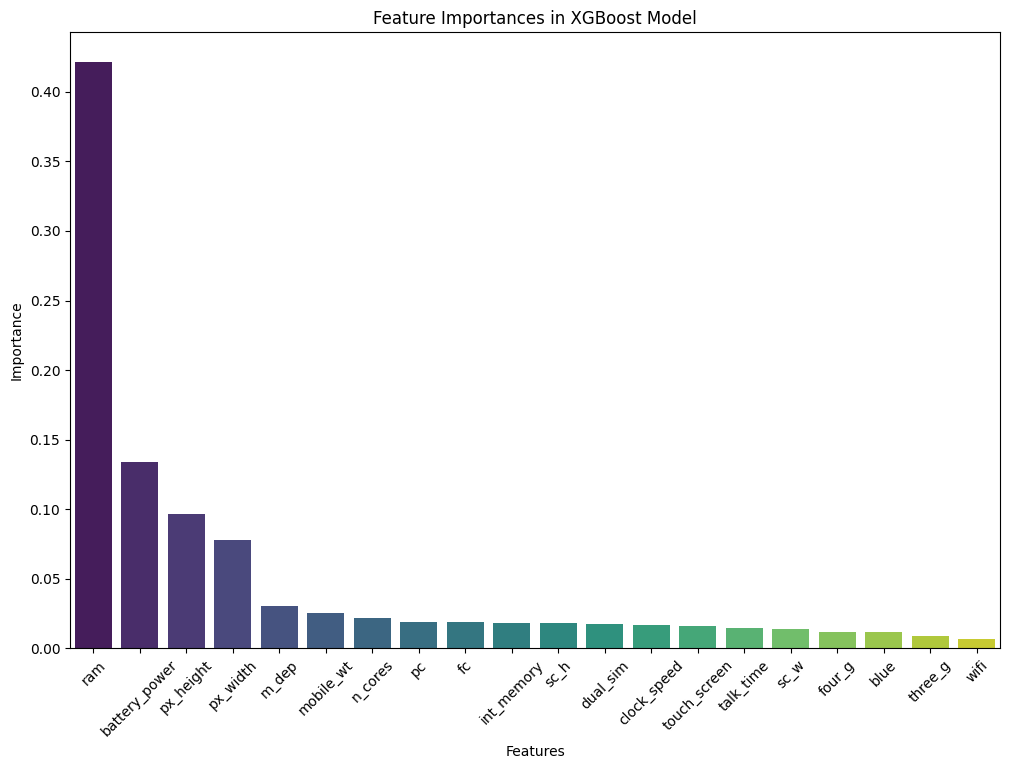

In [29]:
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance.index, y=feature_importance['Importance'], palette="viridis")
plt.title('Feature Importances in XGBoost Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

In [30]:
top_features = feature_importance.head(5)
print("Top 5 Important Features:")
print(top_features)

Top 5 Important Features:
               Importance
Feature                  
ram              0.421694
battery_power    0.134269
px_height        0.096689
px_width         0.077731
m_dep            0.030650


# **MODEL EVALUATION**

## **NEURAL NETWORK**

### **Accuracy**

In [31]:
accuracy = model_nn.evaluate(test_ds)
print(f'Accuracy: {accuracy}')

13/13 [==============================] - 0s 6ms/step - loss: 0.2218 - accuracy: 0.9450
Accuracy: [0.2218443751335144, 0.9449999928474426]


### **Predict**

The steps in making predictions are as follows:
- Input data is passed into the network to be processed step by step.
- Forward propagation, where the input data will be processed in a forward direction through each network to produce an output.
- The softmax activation function is applied to the output of the final dense layer to get probabilities for each class.
- The predicted class is the one with the highest probability.




In [32]:
# Predict
y_pred_probs_nn = model_nn.predict(test_ds)
y_pred_nn = tf.argmax(y_pred_probs_nn, axis=1)

13/13 [==============================] - 2s 8ms/step


In [55]:
y_pred_probs_nn

array([[1.1764974e-11, 5.7305338e-06, 2.9299134e-01, 7.0700294e-01],
       [1.6081386e-14, 1.0920873e-08, 5.8020917e-03, 9.9419785e-01],
       [2.1041899e-09, 3.0209581e-04, 9.4689518e-01, 5.2802693e-02],
       ...,
       [7.8229952e-01, 2.1767491e-01, 2.5416541e-05, 8.1559915e-12],
       [2.8675852e-06, 4.4830784e-02, 9.5438033e-01, 7.8595895e-04],
       [2.4422516e-07, 1.2284250e-02, 9.8691291e-01, 8.0256991e-04]],
      dtype=float32)

In [33]:
y_pred_nn

<tf.Tensor: shape=(400,), dtype=int64, numpy=
array([0, 2, 1, 3, 1, 1, 2, 0, 3, 1, 0, 0, 2, 3, 3, 2, 3, 3, 1, 0, 0, 2,
       0, 2, 0, 1, 3, 3, 2, 0, 0, 0, 3, 0, 1, 1, 2, 0, 3, 0, 2, 3, 2, 0,
       2, 3, 2, 1, 3, 1, 3, 1, 0, 0, 1, 0, 1, 3, 0, 0, 1, 3, 3, 1, 0, 0,
       3, 3, 1, 2, 2, 2, 0, 1, 2, 0, 1, 3, 2, 2, 3, 2, 1, 0, 1, 3, 1, 3,
       3, 0, 3, 3, 2, 1, 3, 2, 2, 3, 1, 1, 0, 0, 1, 0, 0, 3, 2, 0, 1, 1,
       0, 0, 3, 1, 3, 2, 3, 2, 0, 2, 1, 3, 2, 1, 3, 3, 0, 3, 0, 2, 3, 0,
       2, 2, 0, 3, 1, 0, 0, 2, 3, 1, 3, 2, 0, 0, 0, 1, 1, 2, 3, 1, 1, 0,
       2, 2, 0, 1, 0, 2, 2, 3, 3, 3, 1, 0, 0, 2, 2, 3, 3, 0, 0, 0, 3, 1,
       1, 2, 1, 0, 0, 0, 0, 0, 3, 2, 0, 3, 0, 0, 0, 0, 1, 3, 3, 1, 0, 1,
       2, 1, 1, 2, 2, 3, 3, 3, 1, 2, 0, 0, 0, 2, 1, 1, 3, 1, 0, 2, 1, 1,
       3, 2, 3, 0, 0, 2, 1, 3, 0, 1, 1, 0, 1, 3, 2, 0, 1, 3, 3, 0, 1, 3,
       3, 3, 0, 3, 1, 2, 3, 3, 2, 1, 1, 3, 3, 1, 3, 3, 3, 2, 3, 0, 2, 2,
       3, 2, 3, 0, 2, 3, 2, 3, 2, 1, 0, 2, 0, 2, 3, 1, 3, 1, 0, 3, 1, 2,
     

### **Evaluation Metric**

In [34]:
# Evaluation Metric
print(f'Accuracy: {accuracy_score(y_test, y_pred_nn)}')
print(f'Precision: {precision_score(y_test, y_pred_nn, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_pred_nn, average="weighted")}')
print(f'F1-Score: {f1_score(y_test, y_pred_nn, average="weighted")}')

Accuracy: 0.945
Precision: 0.9451004143368664
Recall: 0.945
F1-Score: 0.9445358010257542


### **Confussion Matrix**

In [35]:
# Confusion Matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)
print("Confusion Matrix NN:")
print(cm_nn)

Confusion Matrix NN:
[[104   1   0   0]
 [  5  84   2   0]
 [  0   3  81   8]
 [  0   0   3 109]]


### **Classification Report**

In [37]:
# Classification Report
cr_nn = classification_report(y_test, y_pred_nn)
print("\nClassification Report Neural Network:")
print(cr_nn)


Classification Report Neural Network:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       105
           1       0.95      0.92      0.94        91
           2       0.94      0.88      0.91        92
           3       0.93      0.97      0.95       112

    accuracy                           0.94       400
   macro avg       0.95      0.94      0.94       400
weighted avg       0.95      0.94      0.94       400



### **ROC Score**

In [38]:
# ROC Score
roc_auc_scores = roc_auc_score(y_test, y_pred_probs_nn, multi_class='ovo')
print("ROC AUC Score:", roc_auc_scores)

ROC AUC Score: 0.9969261080965274


### **Plot ROC**

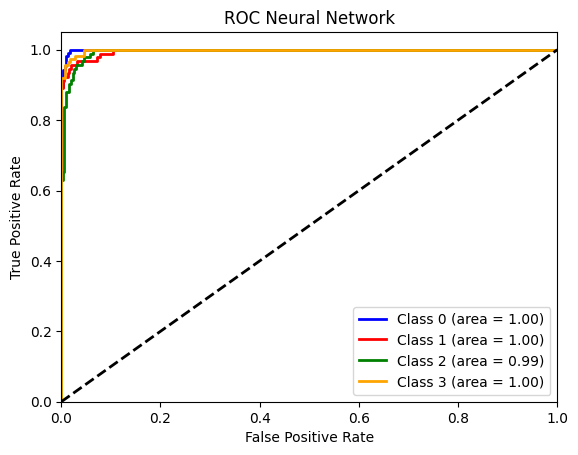

In [39]:
# Plot ROC
plt.figure()
colors = ['blue', 'red', 'green', 'orange']
for i in range(4):
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs_nn[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Neural Network')
plt.legend(loc='lower right')
plt.show()

## **XGBOOST**

### **Predict**

The process involves making predictions using each tree in the ensemble and then aggregating these predictions. The steps in making predictions are as follows:
- For each sample in X_test, each tree makes a prediction.
- XGBoost uses boosting, which means each tree's prediction is added to the previous trees' predictions.
- After all tree predictions are added, the final prediction is obtained. If the model is for classification, this final value is used to determine the class label (softmax function).



In [40]:
# Predict
y_pred_xgb = best_xgb.predict(X_test)
y_pred_xgb

array([0, 2, 1, 3, 1, 1, 2, 0, 3, 1, 0, 1, 2, 3, 2, 2, 3, 3, 1, 0, 0, 1,
       1, 2, 0, 1, 3, 2, 2, 0, 0, 0, 3, 0, 1, 1, 2, 0, 3, 0, 2, 3, 2, 0,
       3, 2, 1, 1, 3, 1, 3, 1, 0, 0, 0, 1, 1, 2, 0, 0, 1, 3, 3, 1, 0, 0,
       3, 3, 1, 2, 2, 2, 0, 1, 2, 0, 0, 3, 2, 2, 3, 2, 1, 0, 1, 3, 1, 3,
       3, 0, 3, 3, 2, 1, 3, 2, 2, 3, 1, 1, 0, 0, 1, 0, 0, 3, 2, 0, 1, 1,
       0, 0, 3, 1, 2, 2, 3, 2, 0, 2, 1, 3, 2, 1, 3, 3, 0, 3, 0, 2, 3, 0,
       2, 2, 0, 3, 1, 0, 0, 2, 3, 0, 2, 2, 0, 0, 0, 1, 1, 2, 3, 1, 1, 0,
       2, 2, 0, 1, 0, 1, 2, 3, 2, 2, 1, 0, 0, 2, 2, 3, 3, 1, 1, 0, 3, 1,
       2, 2, 1, 0, 0, 0, 0, 0, 3, 2, 0, 3, 0, 0, 0, 0, 1, 3, 3, 1, 0, 1,
       1, 1, 1, 1, 2, 2, 3, 3, 1, 2, 0, 0, 0, 2, 1, 1, 3, 1, 0, 2, 1, 1,
       3, 2, 3, 0, 0, 2, 1, 3, 0, 1, 2, 0, 2, 3, 2, 1, 1, 3, 3, 0, 1, 3,
       3, 3, 0, 3, 1, 2, 3, 3, 2, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 1, 2,
       2, 1, 2, 0, 2, 3, 2, 2, 2, 1, 0, 1, 0, 3, 3, 1, 3, 1, 0, 3, 1, 2,
       0, 0, 3, 0, 1, 2, 3, 3, 3, 1, 0, 0, 1, 3, 3,

### **Probability**

In [41]:
# Probability
y_pred_probs_xgb = best_xgb.predict_proba(X_test)
print(y_pred_probs_xgb)

[[9.9930334e-01 6.8816036e-04 5.6351510e-06 2.8256468e-06]
 [2.0649713e-04 4.4723582e-03 9.9521613e-01 1.0506645e-04]
 [1.6548836e-03 9.9751830e-01 6.1345228e-04 2.1338854e-04]
 ...
 [1.0245005e-03 9.7667056e-01 2.1862783e-02 4.4214181e-04]
 [1.7009232e-04 9.9034750e-01 9.3114236e-03 1.7090060e-04]
 [5.1436735e-05 6.1962113e-04 9.9374098e-01 5.5879410e-03]]


### **Evaluation Metric**

In [42]:
# Evaluation Metric
print(f'Accuracy: {accuracy_score(y_test, y_pred_xgb)}')
print(f'Precision: {precision_score(y_test, y_pred_xgb, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_pred_xgb, average="weighted")}')
print(f'F1-Score: {f1_score(y_test, y_pred_xgb, average="weighted")}')

Accuracy: 0.9075
Precision: 0.9080434006869172
Recall: 0.9075
F1-Score: 0.9076272051888165


### **Confussion Matrix**

In [43]:
# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix XGBOOST:")
print(cm_xgb)

Confusion Matrix XGBOOST:
[[100   5   0   0]
 [  6  82   3   0]
 [  0   7  79   6]
 [  0   0  10 102]]


### **Classification Report**

In [44]:
# Classification Report
cr_xgb = classification_report(y_test, y_pred_xgb)
print("\nClassification Report XGBOOST:")
print(cr_xgb)


Classification Report XGBOOST:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       105
           1       0.87      0.90      0.89        91
           2       0.86      0.86      0.86        92
           3       0.94      0.91      0.93       112

    accuracy                           0.91       400
   macro avg       0.90      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



### **ROC Score**

In [45]:
# ROC Score
xgb_roc_auc = roc_auc_score(y_test, y_pred_probs_xgb, multi_class='ovr')
print(f'ROC AUC Score: {xgb_roc_auc}')

ROC AUC Score: 0.991549070627018


### **Plot ROC**

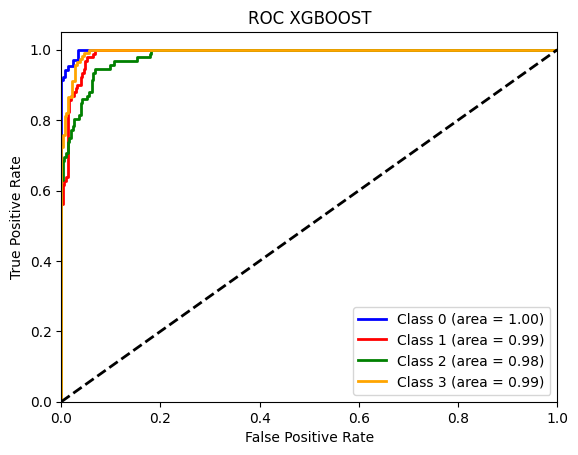

In [46]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):  # 4 CLASS
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_probs_xgb[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC
plt.figure()
colors = ['blue', 'red', 'green', 'orange']
for i in range(4):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC XGBOOST')
plt.legend(loc="lower right")
plt.show()

# **PREDICTION**

## **Read Data**

In [47]:
data_testing = pd.read_csv("test.csv")

## **Data Preprocessing**

### **Standardize**

In [48]:
def scale_data(data_testing):
    scaled_data_testing = data_testing.copy()
    num_fit = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt',
               'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'talk_time']
    scaler = StandardScaler()
    scaled_data_testing[num_fit] = scaler.fit_transform(scaled_data_testing[num_fit])
    return scaled_data_testing

scaled_data_testing = scale_data(data_testing)
print(scaled_data_testing)

       id  battery_power  blue  clock_speed  dual_sim        fc  four_g  \
0       1      -0.475451     1     0.312601         1  2.108676       0   
1       2      -0.942782     1    -1.255832         1 -0.132927       1   
2       3       1.292077     1     1.519087         0 -0.805408       0   
3       4       0.688249     0    -1.255832         1  3.005317       1   
4       5       0.429135     0    -0.169994         0  1.436195       1   
..    ...            ...   ...          ...       ...       ...     ...   
995   996       1.044531     1     0.433249         0 -1.029568       1   
996   997      -1.479519     0     0.312601         1 -1.029568       0   
997   998      -0.146932     0    -0.169994         0 -0.805408       1   
998   999       0.658173     1    -1.255832         1 -1.029568       0   
999  1000       0.049718     1    -1.255832         0 -0.132927       1   

     int_memory     m_dep  mobile_wt  ...        pc  px_height  px_width  \
0     -1.581269 -1.4872

## **Neural Network**

### **Data Convertion**

In [49]:
def data_to_dataset(dataframe, batch_size=32):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices(dict(dataframe))
    ds = ds.batch(batch_size)
    return ds

test_ds = data_to_dataset(scaled_data_testing)

### **Predict**

In [56]:
y_pred_probs_nn = model_nn.predict(test_ds)
y_pred_nn = tf.argmax(y_pred_probs_nn, axis=1).numpy()

print("Neural Network Predict:")
print(y_pred_nn)

32/32 [==============================] - 0s 6ms/step
Neural Network Predict:
[3 3 2 3 1 3 3 1 3 0 3 3 0 0 2 0 2 1 3 2 1 3 1 1 3 0 2 0 2 0 2 0 3 0 1 1 3
 1 2 1 1 2 0 0 0 1 0 3 1 2 1 0 3 0 3 0 3 1 0 3 3 3 0 1 0 1 2 3 1 2 1 2 2 3
 3 0 2 0 1 3 0 3 3 0 3 0 3 1 3 0 1 2 2 1 2 2 0 2 1 3 1 0 0 3 0 2 0 1 2 3 3
 3 1 3 3 3 3 2 3 0 0 3 2 1 2 0 3 2 2 2 0 2 1 1 3 1 1 0 3 2 1 2 1 2 2 3 3 3
 2 3 2 3 1 0 3 2 3 3 3 3 3 2 3 3 3 3 1 0 3 0 0 0 2 0 0 1 0 0 1 2 1 0 0 1 1
 2 2 1 0 0 0 1 0 3 1 0 2 2 3 3 1 1 3 3 3 2 2 1 0 0 1 3 0 2 3 3 0 2 0 3 2 3
 3 1 0 1 0 3 0 1 0 2 2 1 3 0 3 0 3 1 2 0 0 2 0 3 3 3 1 1 3 0 0 2 3 3 1 3 1
 1 3 2 1 2 3 3 3 1 0 1 2 3 1 1 3 2 0 3 0 0 2 0 0 3 2 3 3 2 0 3 3 2 3 1 2 1
 2 0 2 3 1 0 0 3 0 3 0 1 2 0 2 3 1 3 2 2 0 2 0 0 0 1 3 2 0 0 0 3 2 0 2 3 1
 2 2 2 3 1 3 3 2 2 2 3 3 0 3 0 3 1 3 1 2 3 0 1 0 3 1 3 2 3 0 0 0 0 2 0 0 2
 2 0 2 2 2 0 1 0 0 3 2 0 3 1 2 2 1 2 3 1 1 2 2 1 2 0 1 1 0 3 2 0 0 1 0 0 1
 1 0 0 0 2 2 3 2 3 0 3 0 3 0 1 1 0 2 0 3 2 3 3 1 3 1 3 1 3 2 0 1 2 1 1 0 0
 0 1 2 1 0 3 2 0 2 3 0 

## **XGBOOST**

### **Preparing Data**

In [52]:
data_predict = scaled_data_testing[['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc',
                                    'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']]

In [53]:
data_predict.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,-0.475451,1,0.312601,1,2.108676,0,-1.581269,-1.487247,1.535535,-0.580671,0.976026,-0.926990,0.391912,1.229373,0.001158,7,-1.653355,0,1,0
1,-0.942782,1,-1.255832,1,-0.132927,1,1.509303,1.006341,1.478120,0.293833,0.319433,0.274729,-0.871028,1.614643,-1.388231,0,-0.743418,1,0,0
2,1.292077,1,1.519087,0,-0.805408,0,-0.367116,1.362567,1.334582,-0.580671,-0.993754,1.485693,0.287236,0.236313,1.158982,10,-0.197456,0,1,1
3,0.688249,0,-1.255832,1,3.005317,1,-0.477493,-0.062340,-1.249091,1.605590,1.632619,-0.767532,1.165604,1.612804,-0.461972,0,-0.743418,1,1,0
4,0.429135,0,-0.169994,0,1.436195,1,0.847037,-0.062340,-0.904602,0.731085,1.304323,0.281662,-0.977979,-0.336535,0.695852,8,-0.743418,1,0,1


### **Predict**

In [57]:
y_pred_xgb = best_xgb.predict(data_predict)

print("XGBoost Predict:")
print(y_pred_xgb)

XGBoost Predict:
[3 3 2 3 1 3 3 1 3 0 3 3 0 0 2 0 2 1 3 2 1 3 1 1 3 0 2 0 3 0 2 0 3 0 1 1 3
 1 2 1 1 2 0 0 0 1 0 3 1 2 1 0 3 0 3 1 3 1 1 3 3 2 0 1 1 1 1 3 1 2 1 2 2 3
 3 0 2 0 2 3 1 3 3 0 3 0 3 1 3 0 1 2 2 0 2 2 1 2 1 2 1 0 0 3 0 2 0 1 2 3 3
 2 1 3 3 3 3 2 3 0 0 3 1 1 2 0 3 2 3 1 0 2 1 1 3 1 1 0 3 2 1 2 1 2 2 3 3 2
 2 3 2 3 0 0 3 2 3 3 3 3 2 2 3 3 3 3 1 0 3 0 0 0 1 1 0 1 0 0 1 2 0 0 0 1 1
 2 2 1 0 0 0 1 0 3 2 0 2 2 2 3 1 2 2 3 3 2 2 1 0 0 1 2 0 2 3 3 0 2 0 3 2 3
 3 1 0 1 0 3 0 1 0 2 2 1 3 1 3 0 3 1 2 0 0 2 1 3 2 3 1 1 3 0 0 2 3 3 1 3 1
 1 3 2 1 2 3 3 3 1 0 1 2 3 1 1 3 2 0 3 0 1 2 0 0 3 2 3 3 2 1 3 3 2 3 2 2 1
 2 0 2 3 1 0 0 3 0 3 0 1 2 0 2 3 1 3 2 2 1 2 0 0 0 1 3 2 0 0 0 3 2 0 2 3 1
 2 3 2 3 1 3 3 2 2 2 3 3 0 3 0 3 1 3 1 3 3 0 1 0 3 1 3 2 3 0 0 0 0 2 0 0 2
 2 1 2 2 2 0 1 0 0 3 2 0 3 1 2 2 1 2 3 1 1 2 2 1 2 0 1 1 0 3 2 1 0 1 0 0 1
 1 0 0 0 2 2 3 2 3 0 2 0 3 0 1 1 1 1 0 3 2 3 3 1 3 1 3 1 3 2 0 1 2 1 1 0 0
 0 1 2 1 0 3 2 0 2 3 0 0 3 1 1 0 2 2 3 0 3 0 2 3 3 3 0 2 0 2 2 0 1 2 0 0 1
 1 1 3 3